# Tarea 3 - Optimización
- Integrantes: 
    - Samuel Coña J. - 2020451320
    - Daniel Lopez B. -
    - Dayan Sáez C. - 2020444854
    - Luis Valenzuela C. - 2020437548

Instancia a resolver:

<table>
  <tr>
    <th></th>
    <th colspan="4">
      Máquinas r</th>
  </tr>
  <tr>
    <th>Trabajo i</th>
    <th>M<sub>1</th>
    <th>M<sub>2</th>
    <th>M<sub>3</th>
    <th>M<sub>4</th>
  </tr>
  <tr>
    <th>J<sub>1</th>
    <th>9</th>
    <th>13</th>
    <th>15</th>
    <th>20</th>
  </tr>
  <tr>
    <th>J<sub>2</th>
    <th>11</th>
    <th>17</th>
    <th>18</th>
    <th>24</th>
  </tr>
  <tr>
    <th>J<sub>3</th>
    <th>8</th>
    <th>12</th>
    <th>14</th>
    <th>18</th>
  </tr>
  <tr>
    <th>J<sub>4</th>
    <th>6</th>
    <th>10</th>
    <th>12</th>
    <th>15</th>
  </tr>

### Párametros de los modelos
$ T_{ri} \text{: Duración de proceso del trabajo i en máquina r.} \\$
$ B_{rj} \text{: Tiempo de inicio del trabajo j, en la posición de la secuencia, en máquina r.} \\$
$ C_{ri} \text{: Tiempo de finalización del trabajo i en la máquina r.} \\$
$ D_{ki} \text{: 1, si el trabajo i está programado en cualquier momento antes del trabajo k. 0, en caso contrario.} \\$
$ E_{rj} \text{: Tiempo de finalización del trabajo en la posición j de la secuencia, en la máquina r.} \\$
$ q_{rik} \text{: Relación de prioridad de los trabajos i y k en la máquina r.} \\$
$ S_{ri} \text{: Tiempo de inicio del trabajo i en la máquina r.} \\$
$ X_{rj} \text{: Tiempo de espera de la máquina r, antes del inicio del trabajo en la posición j de la secuencia.} \\$
$ Y_{rj} \text{: Tiempo de espera del trabajo en la posición j de la secuencia, después de haber finalizado su procesamiento en la máquina r.} \\$
$ Z_{ij} \text{: 1, si el trabajo i es asignado a la secuencia en la posición j. 0, en caso contrario.}$

### Modelo Wagner

$$ Min \quad C_{max} = C_{MN} $$
$$ \text{s.a } \quad \sum_{j=1}^{N} Z_{ij} = 1; \quad (1 \le i \le N), \quad (1) $$ 
$$ \sum_{i=1}^{N} Z_{ij} = 1; \quad (1 \le j \le N), \quad (2)$$
$$ \sum_{i=1}^{N} T_{ri}Z_{i,j+1} - \sum_{i=1}^{N} T_{r+1,i}Z_{ij} + X_{r,j+1} - X_{r+1,j+1} + Y_{r,j+1} - Y_{rj} = 0; \quad (1 \le r \le M-1;1 \le j \le N-1), \quad (3)
$$

$$ \sum_{i=1}^{N} T_{ri}Z_{i1} + X_{r1} - X_{r+1,1} + Y_{r1} = 0; \quad (1 \le r \le M-1), \quad (4) $$

$$ C_{MN} = \sum_{i=1}^{N} T_{Mi} + \sum_{p=1}^{N} X_{Mp}. \quad (5) $$

#### Implementación en PuLP

Objective Value: 105.0


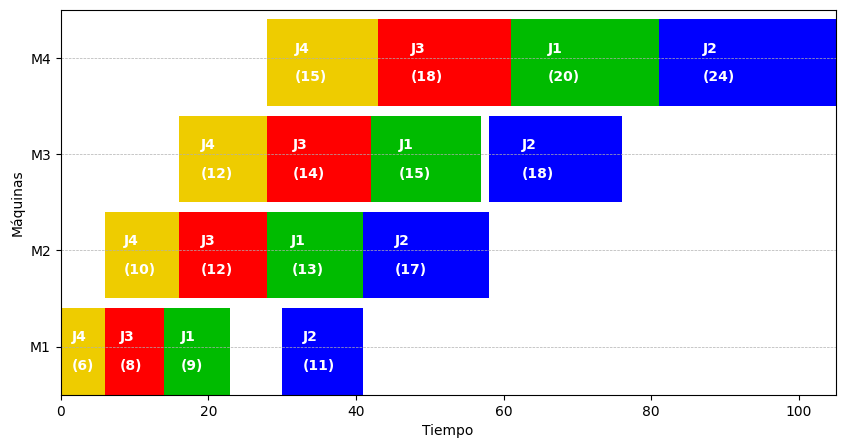

In [20]:
import pulp as lp
import numpy as np
import matplotlib.pyplot as plt

T = np.array([[9, 13, 15, 20],
              [11, 17, 18, 24],
              [8, 12, 14, 18],
              [6, 10, 12, 15]])

T = T.transpose()

# Crear el problema de minimización
model = lp.LpProblem("Wagner_Model", lp.LpMinimize)

N = len(T[0])  # Numero de tareas
M = len(T)     # Numero de maquinas

# Definir las variables
Z = lp.LpVariable.dicts("Z", (range(N), range(N)), cat='Binary')
X = lp.LpVariable.dicts("X", (range(M), range(N)), lowBound=0, cat='Integer')
Y = lp.LpVariable.dicts("Y", (range(M), range(N)), lowBound=0, cat='Integer')

# Definir la función objetivo
model += lp.lpSum(T[M - 1][i] for i in range(N)) + \
         lp.lpSum(X[M - 1][p] for p in range(N))

# Definir las restricciones
for i in range(N):
    model += lp.lpSum(Z[i][j] for j in range(N)) == 1
    
for j in range(N):
    model += lp.lpSum(Z[i][j] for i in range(N)) == 1

for r in range(M - 1):
    for j in range(N - 1):
        model += lp.lpSum(T[r][i] * Z[i][j + 1] for i in range(N)) - \
                 lp.lpSum(T[r + 1][i] * Z[i][j] for i in range(N)) + \
                 X[r][j + 1] - X[r + 1][j + 1] + Y[r][j + 1] - Y[r][j] == 0

for r in range(M - 1):
    model += lp.lpSum(T[r][i] * Z[i][0] for i in range(N)) +  X[r][0] - X[r + 1][0] + Y[r][0] == 0

# Resolver el problema
solution = model.solve()

# Imprimir la solución
print("Objective Value:", lp.value(model.objective))
 
# Carta Gannt
# Determinar el orden de las tareas
unos_tareas = [(i, j) for i in range(N) for j in range(N) if Z[i][j].varValue == 1]
orden_tareas = [tupla[0] for tupla in sorted(unos_tareas, key=lambda x: x[1])]

# Matriz de tiempos
matriz = []
for r in range(M):
    maquina = []
    for j in range(N):
        if(j == 0):
            maquina.append([int(X[r][j].varValue), int(X[r][j].varValue) + T[r][orden_tareas[j]]])
        else:
            maquina.append([maquina[-1][1]+int(X[r][j].varValue), maquina[-1][1] + int(X[r][j].varValue) + T[r][orden_tareas[j]]])
    matriz.append(maquina)

# Graficar la carta de Gantt
fig, gantt = plt.subplots(figsize=(10, 5))
gantt.set_xlabel('Tiempo')
gantt.set_ylabel('Máquinas')
gantt.set_xlim(0, lp.value(model.objective))
gantt.set_ylim(0, M * 10)
gantt.set_yticks(np.arange(5, M * 10, 10))
gantt.set_yticklabels(['M' + str(i) for i in range(1, M+1)])
gantt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
colores = ['#00BB00', 'blue', 'red', '#EECC00']

for r in range(M):
    for j in range(N):
        inicio = matriz[r][j][0]
        duracion = matriz[r][j][1] - matriz[r][j][0]
        gantt.broken_barh([(inicio, duracion)], ((r) * 10, 9), facecolors=colores[orden_tareas[j]])
        gantt.text(x=(inicio + duracion/4), y=((r) * 10 + 6), s='J'+str(orden_tareas[j]+1), va='center', color='white', fontweight='bold')
        gantt.text(x=(inicio + duracion/4), y=((r) * 10 + 3), s='('+str(duracion)+')', va='center', color='white', fontweight='bold')

#### Implementación en CPLEX

Objective Value: 105.0


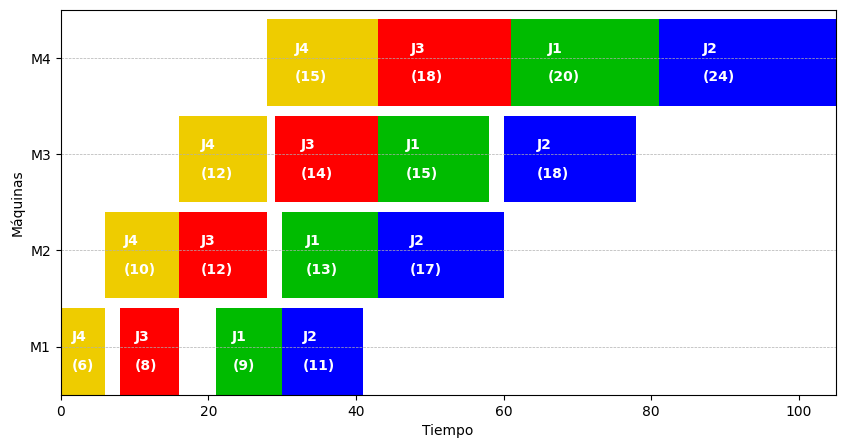

In [21]:
from docplex.mp.model import Model
import matplotlib.pyplot as plt
import numpy as np

T = np.array([[9, 13, 15, 20],
              [11, 17, 18, 24],
              [8, 12, 14, 18],
              [6, 10, 12, 15]])

T = T.transpose()

# Crear el modelo
model = Model(name="Wagner_Model")

N = len(T[0])  # Numero de tareas
M = len(T)     # Numero de maquinas

# Definir las variables
Z = {(i, j): model.binary_var(name=f"Z_{i}_{j}") for i in range(N) for j in range(N)}
X = {(r, j): model.integer_var(name=f"X_{r}_{j}", lb=0) for r in range(M) for j in range(N)}
Y = {(r, j): model.integer_var(name=f"Y_{r}_{j}", lb=0) for r in range(M) for j in range(N)}

# Definir la función objetivo
model.minimize(model.sum(T[M-1][i] for i in range(N)) +
               model.sum(X[M-1,p] for p in range(N)))

# Definir las restricciones
for i in range(N):
    model.add_constraint(model.sum(Z[i,j] for j in range(N)) == 1)
    
for j in range(N):
    model.add_constraint(model.sum(Z[i,j] for i in range(N)) == 1)

for r in range(M - 1):
    for j in range(N - 1):
        model.add_constraint(model.sum(T[r][i] * Z[i,j + 1] for i in range(N)) -
                             model.sum(T[r + 1][i] * Z[i,j] for i in range(N)) +
                             X[r,j+1] - X[r + 1,j + 1] + Y[r,j + 1] - Y[r,j] == 0)

for r in range(M - 1):
    model.add_constraint(model.sum(T[r][i] * Z[i,0] for i in range(N)) +
                         X[r,0] - X[r + 1,0] + Y[r,0] == 0)

# Resolver el problema
solution = model.solve()

# Imprimir la solución
print("Objective Value:", solution.get_objective_value())

# Carta Gannt
# Determinar el orden de las tareas
unos_tareas = [(i, j) for i in range(N) for j in range(N) if solution.get_value(Z[i, j]) == 1]
orden_tareas = [tupla[0] for tupla in sorted(unos_tareas, key=lambda x: x[1])]

# Matriz de tiempos
matriz = []
for r in range(M):
    maquina = []
    for j in range(N):
        if(j == 0):
            maquina.append([int(solution.get_value(X[r, j])), int(solution.get_value(X[r, j])) + T[r][orden_tareas[j]]])
        else:
            maquina.append([maquina[-1][1]+int(solution.get_value(X[r, j])), maquina[-1][1] + int(solution.get_value(X[r, j])) + T[r][orden_tareas[j]]])
    matriz.append(maquina)

# Graficar la carta de Gantt
fig, gantt = plt.subplots(figsize=(10, 5))
gantt.set_xlabel('Tiempo')
gantt.set_ylabel('Máquinas')
gantt.set_xlim(0, solution.get_objective_value())
gantt.set_ylim(0, M * 10)
gantt.set_yticks(np.arange(5, M * 10, 10))
gantt.set_yticklabels(['M' + str(i) for i in range(1, M+1)])
gantt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
colores = ['#00BB00', 'blue', 'red', '#EECC00']

for r in range(M):
    for j in range(N):
        inicio = matriz[r][j][0]
        duracion = matriz[r][j][1] - matriz[r][j][0]
        gantt.broken_barh([(inicio, duracion)], ((r) * 10, 9), facecolors=colores[orden_tareas[j]])
        gantt.text(x=(inicio + duracion/4), y=((r) * 10 + 6), s='J'+str(orden_tareas[j]+1), va='center', color='white', fontweight='bold')
        gantt.text(x=(inicio + duracion/4), y=((r) * 10 + 3), s='('+str(duracion)+')', va='center', color='white', fontweight='bold')


#### Implementación en GUROBI

Objective Value: 105.0


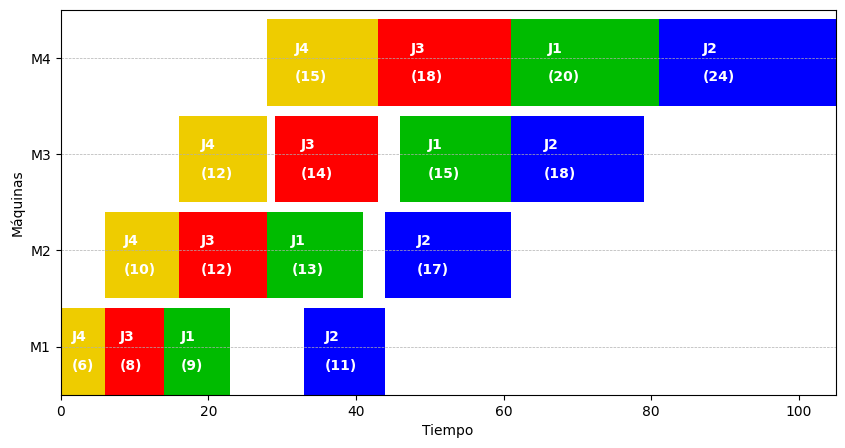

In [22]:
import gurobipy as gp
import matplotlib.pyplot as plt
import numpy as np

T = np.array([[9, 13, 15, 20],
              [11, 17, 18, 24],
              [8, 12, 14, 18],
              [6, 10, 12, 15]])

T = T.transpose()

# Crear el modelo
model = gp.Model("Wagner_Model")

N = len(T[0])  # Numero de tareas
M = len(T)     # Numero de maquinas

# Definir las variables
Z = model.addVars(N, N, vtype=gp.GRB.BINARY, name="Z")
X = model.addVars(M, N, vtype=gp.GRB.INTEGER, lb=0, name="X")
Y = model.addVars(M, N, vtype=gp.GRB.INTEGER, lb=0, name="Y")

# Definir la función objetivo
model.setObjective(gp.quicksum(T[M-1][i] for i in range(N)) +
                   gp.quicksum(X[M-1, p] for p in range(N)), gp.GRB.MINIMIZE)

# Definir las restricciones
for i in range(N):
    model.addConstr(gp.quicksum(Z[i, j] for j in range(N)) == 1)
    
for j in range(N):
    model.addConstr(gp.quicksum(Z[i, j] for i in range(N)) == 1)

for r in range(M - 1):
    for j in range(N - 1):
        model.addConstr(gp.quicksum(T[r][i] * Z[i,j+1] for i in range(N)) -
                        gp.quicksum(T[r+1][i] * Z[i,j] for i in range(N)) +
                        X[r,j+1] - X[r+1,j+1] + Y[r,j+1] - Y[r,j] == 0)

for r in range(M - 1):
    model.addConstr(gp.quicksum(T[r][i] * Z[i,0] for i in range(N)) +
                    X[r,0] - X[r+1,0] + Y[r,0] == 0)

# Resolver el problema
model.setParam('OutputFlag', False)
model.optimize()

# Imprimir la solución
print("Objective Value:", model.objVal)

# Carta Gannt
# Determinar el orden de las tareas
unos_tareas = [(i, j) for i in range(N) for j in range(N) if Z[i, j].x == 1]
orden_tareas = [tupla[0] for tupla in sorted(unos_tareas, key=lambda x: x[1])]

# Matriz de tiempos
matriz = []
for r in range(M):
    maquina = []
    for j in range(N):
        if(j == 0):
            maquina.append([int(X[r, j].x), int(X[r, j].x) + T[r][orden_tareas[j]]])
        else:
            maquina.append([maquina[-1][1]+int(X[r, j].x), maquina[-1][1] + int(X[r, j].x) + T[r][orden_tareas[j]]])
    matriz.append(maquina)

# Graficar la carta de Gantt
fig, gantt = plt.subplots(figsize=(10, 5))
gantt.set_xlabel('Tiempo')
gantt.set_ylabel('Máquinas')
gantt.set_xlim(0, model.objVal)
gantt.set_ylim(0, M * 10)
gantt.set_yticks(np.arange(5, M * 10, 10))
gantt.set_yticklabels(['M' + str(i) for i in range(1, M+1)])
gantt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
colores = ['#00BB00', 'blue', 'red', '#EECC00']

for r in range(M):
    for j in range(N):
        inicio = matriz[r][j][0]
        duracion = matriz[r][j][1] - matriz[r][j][0]
        gantt.broken_barh([(inicio, duracion)], ((r) * 10, 9), facecolors=colores[orden_tareas[j]])
        gantt.text(x=(inicio + duracion/4), y=((r) * 10 + 6), s='J'+str(orden_tareas[j]+1), va='center', color='white', fontweight='bold')
        gantt.text(x=(inicio + duracion/4), y=((r) * 10 + 3), s='('+str(duracion)+')', va='center', color='white', fontweight='bold')



### Modelo Wilson
$$ Min \quad C_{max} = B_{MN} + \sum_{i=1}^{N}T_{Mi}Z_{iN} $$
$$ \text{s.a } \quad \sum_{j=1}^{N} Z_{ij} = 1; \quad (1 \le i \le N), \quad (1) $$ 
$$ \sum_{i=1}^{N} Z_{ij} = 1; \quad (1 \le j \le N), \quad (2)$$
$$ B_{1j}+\sum_{i=1}^{N} T_{1i}Z_{1j} = B_{1,j+1}; \quad (1\leq j \leq N-1), \quad (3)$$
$$ B_{11} = 0, \quad(4)$$
$$ B_{r1} + \sum_{i=1}^{N} T_{ri}Z_{i1} = B_{r+1,1}; \quad (1\leq r \leq M-1),\quad (5) $$

$$ B_{rj} + \sum_{i=1}^{N}T_{ri}Z_{ij} \leq B_{r+1,j}; \quad (1\leq r\leq M-1;2\leq j \leq N), \quad (6) $$
$$ B_{rj} + \sum_{i=1}^N T_{ri}Z_{ij} \leq B_{r,j+1}; \quad (2\leq r\leq M; 1\leq j\leq N-1). \quad (7) $$

#### Implementación en PuLP

Objective Value: 105.0


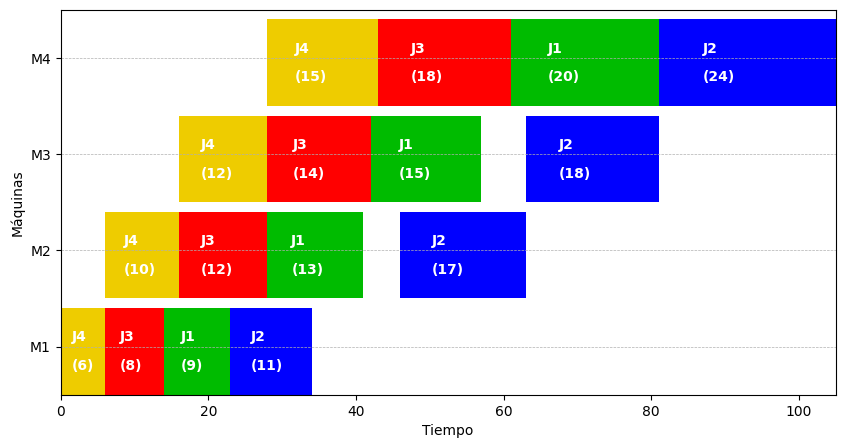

In [23]:
import pulp as lp
import matplotlib.pyplot as plt
import numpy as np

T = np.array([[9, 13, 15, 20],
            [11, 17, 18, 24],
            [8, 12, 14, 18],
            [6, 10, 12, 15]])
T = T.transpose()

# Create the LP problem
model = lp.LpProblem("The_Wilson_Model", lp.LpMinimize)

# Define the decision variables
N = len(T[0])  # Number of jobs
M = len(T)     # Number of machines

Z = lp.LpVariable.dicts("Z", (range(N), range(N)), cat='Binary')
B = lp.LpVariable.dicts("B", (range(N), range(M)), lowBound=0, cat='Integer')

# Define the objective function
model += B[M-1][N-1] + lp.lpSum(T[M-1][i] * Z[i][N-1] for i in range(N))


# Define the constraints
#(6)
for i in range(N):
    model += lp.lpSum(Z[i][j] for j in range(N)) == 1
    
#(7)
for j in range(N):
    model += lp.lpSum(Z[i][j] for i in range(N)) == 1

#(8)
for j in range(N-1):
    model += B[0][j] + lp.lpSum(T[0][i] * Z[i][j] for i in range(N)) == B[0][j+1]

#(9)
model += B[0][0] == 0

#(10)
for r in range(M-1):
    model += (B[r][0] + lp.lpSum(T[r][i] * Z[i][0] for i in range(N)) == B[r+1][0])

#(11)
for r in range(M-1):
    for j in range(1,N):
        model += (B[r][j] + lp.lpSum(T[r][i] * Z[i][j] for i in range(N)) <= B[r+1][j])
        
#(12)
for r in range(1,M):
    for j in range(N-1):
        model += (B[r][j] + lp.lpSum(T[r][i] * Z[i][j] for i in range(N)) <= B[r][j+1])

# Solve the LP problem
solution = model.solve()

# Print the optimal solution
print("Objective Value:", lp.value(model.objective))

# Carta Gannt
import matplotlib.pyplot as plt

unos_tareas = [(i, j) for i in range(N) for j in range(N) if Z[i][j].varValue == 1]
orden_tareas = [tupla[0] for tupla in sorted(unos_tareas, key=lambda x: x[1])]

matriz = []
for r in range(M):
    maquina = []
    for j in range(N):
        maquina.append([int(B[r][j].varValue), int(B[r][j].varValue) + T[r][orden_tareas[j]]])
    matriz.append(maquina)

fig, gantt = plt.subplots(figsize=(10, 5))
gantt.set_xlabel('Tiempo')
gantt.set_ylabel('Máquinas')
gantt.set_xlim(0, lp.value(model.objective))
gantt.set_ylim(0, M * 10)
gantt.set_yticks(np.arange(5, M * 10, 10))
gantt.set_yticklabels(['M' + str(i) for i in range(1, M+1)])
gantt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
colores = ['#00BB00', 'blue', 'red', '#EECC00']

for r in range(M):
    for j in range(N):
        inicio = matriz[r][j][0]
        duracion = matriz[r][j][1] - matriz[r][j][0]
        gantt.broken_barh([(inicio, duracion)], ((r) * 10, 9), facecolors=colores[orden_tareas[j]])
        gantt.text(x=(inicio + duracion/4), y=((r) * 10 + 6), s='J'+str(orden_tareas[j]+1), va='center', color='white', fontweight='bold')
        gantt.text(x=(inicio + duracion/4), y=((r) * 10 + 3), s='('+str(duracion)+')', va='center', color='white', fontweight='bold')

#### Implementación en CPLEX

Objective Value: 105.0


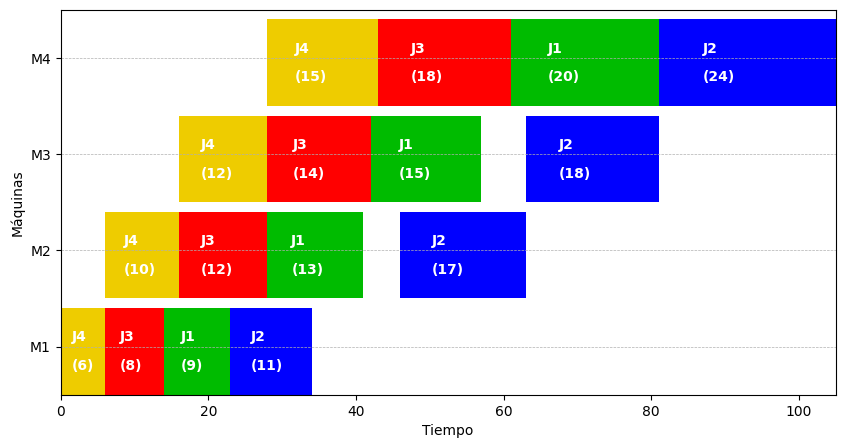

In [24]:
from docplex.mp.model import Model
import matplotlib.pyplot as plt
import numpy as np

T = np.array([[9, 13, 15, 20],
              [11, 17, 18, 24],
              [8, 12, 14, 18],
              [6, 10, 12, 15]])
T = T.transpose()

# Create the model
model = Model(name="The_Wilson_Model")

# Define the decision variables
N = len(T[0])  # Number of jobs
M = len(T)     # Number of machines

Z = {(i, j): model.binary_var(name=f"Z_{i}_{j}") for i in range(N) for j in range(N)}
B = {(i, j): model.integer_var(lb=0, name=f"B_{i}_{j}") for i in range(M) for j in range(N)}

# Define the objective function
model.minimize(B[M-1,N-1] + model.sum(T[M-1][i] * Z[i,N-1] for i in range(N)))

# Define the constraints
#(6)
for i in range(N):
    model.add_constraint(model.sum(Z[i,j] for j in range(N)) == 1)

#(7)
for j in range(N):
    model.add_constraint(model.sum(Z[i,j] for i in range(N)) == 1)

#(8)
for j in range(N-1):
    model.add_constraint(B[0,j] + model.sum(T[0,i] * Z[i,j] for i in range(N)) == B[0,j+1])

#(9)
model.add_constraint(B[0,0] == 0)

#(10)
for r in range(M-1):
    model.add_constraint(B[r, 0] + model.sum(T[r][i] * Z[i,0] for i in range(N)) == B[r+1, 0])

#(11)
for r in range(M-1):
    for j in range(1, N):
        model.add_constraint(B[r, j] + model.sum(T[r, i] * Z[i, j] for i in range(N)) <= B[r+1, j])

#(12)
for r in range(1, M):
    for j in range(N-1):
        model.add_constraint(B[r,j] + model.sum(T[r,i] * Z[i,j] for i in range(N)) <= B[r,j+1])

# Solve the model
model.solve()

# Print the optimal solution
print("Objective Value:", model.objective_value)

# Carta Gannt
unos_tareas = [(i, j) for i in range(N) for j in range(N) if Z[i, j].solution_value == 1]
orden_tareas = [tupla[0] for tupla in sorted(unos_tareas, key=lambda x: x[1])]

matriz = []
for r in range(M):
    maquina = []
    for j in range(N):
        maquina.append([int(B[r, j].solution_value), int(B[r, j].solution_value) + T[r][orden_tareas[j]]])
    matriz.append(maquina)

fig, gantt = plt.subplots(figsize=(10, 5))
gantt.set_xlabel('Tiempo')
gantt.set_ylabel('Máquinas')
gantt.set_xlim(0, model.objective_value)
gantt.set_ylim(0, M * 10)
gantt.set_yticks(np.arange(5, M * 10, 10))
gantt.set_yticklabels(['M' + str(i) for i in range(1, M+1)])
gantt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
colores = ['#00BB00', 'blue', 'red', '#EECC00']

for r in range(M):
    for j in range(N):
        inicio = matriz[r][j][0]
        duracion = matriz[r][j][1] - matriz[r][j][0]
        gantt.broken_barh([(inicio, duracion)], ((r) * 10, 9), facecolors=colores[orden_tareas[j]])
        gantt.text(x=(inicio + duracion/4), y=((r) * 10 + 6), s='J'+str(orden_tareas[j]+1), va='center', color='white', fontweight='bold')
        gantt.text(x=(inicio + duracion/4), y=((r) * 10 + 3), s='('+str(duracion)+')', va='center', color='white', fontweight='bold')

#### Implementacion en GUROBI

Objective Value: 105.0
[3, 2, 0, 1]


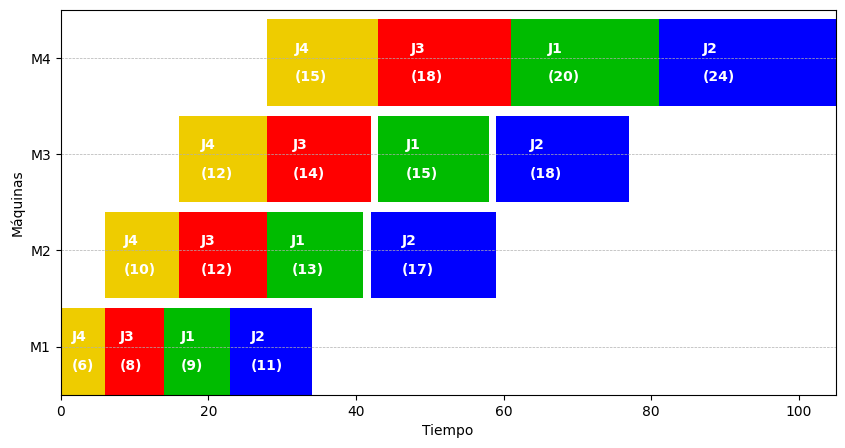

In [25]:
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt
import numpy as np

T = np.array([[9, 13, 15, 20],
              [11, 17, 18, 24],
              [8, 12, 14, 18],
              [6, 10, 12, 15]])
T = T.transpose()

# Create the model
model = gp.Model("The_Wilson_Model")

# Define the decision variables
N = len(T[0])  # Number of jobs
M = len(T)     # Number of machines

Z = model.addVars(N, N, vtype=gp.GRB.BINARY, name="Z")
B = model.addVars(M, N, lb=0, vtype=gp.GRB.INTEGER, name="B")

# Define the objective function
model.setObjective(B[M-1, N-1] + gp.quicksum(T[M-1, i] * Z[i, N-1] for i in range(N)), GRB.MINIMIZE)

# Define the constraints
#(6)
for i in range(N):
    model.addConstr(gp.quicksum(Z[i,j] for j in range(N))== 1)

#(7)
for j in range(N):
    model.addConstr(gp.quicksum(Z[i,j] for i in range(N))== 1)

#(8)
for j in range(N-1):
    model.addConstr(B[0, j] + gp.quicksum(T[0, i] * Z[i, j] for i in range(N)) == B[0, j+1])

#(9)
model.addConstr(B[0, 0] == 0)

#(10)
for r in range(M-1):
    model.addConstr(B[r, 0] + gp.quicksum(T[r, i] * Z[i, 0] for i in range(N)) == B[r+1, 0])

#(11)
for r in range(M-1):
    for j in range(1, N):
        model.addConstr(B[r, j] + gp.quicksum(T[r, i] * Z[i, j] for i in range(N)) <= B[r+1, j])

#(12)
for r in range(1, M):
    for j in range(N-1):
        model.addConstr(B[r, j] + gp.quicksum(T[r, i] * Z[i, j] for i in range(N)) <= B[r, j+1])

# Solve the model
model.setParam('OutputFlag', False)
model.optimize()

# Print the optimal solution
print("Objective Value:", model.objVal)

unos_tareas = [(i, j) for i in range(N) for j in range(N) if Z[i, j].x == 1]
orden_tareas = [tupla[0] for tupla in sorted(unos_tareas, key=lambda x: x[1])]

print (orden_tareas)
matriz = []
for r in range(M):
    maquina = []
    for j in range(N):
        maquina.append([int(B[r, j].x), int(B[r, j].x) + T[r][orden_tareas[j]]])
    matriz.append(maquina)

# Graficar la carta de Gantt
fig, gantt = plt.subplots(figsize=(10, 5))
gantt.set_xlabel('Tiempo')
gantt.set_ylabel('Máquinas')
gantt.set_xlim(0, model.objVal)
gantt.set_ylim(0, M * 10)
gantt.set_yticks(np.arange(5, M * 10, 10))
gantt.set_yticklabels(['M' + str(i) for i in range(1, M+1)])
gantt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
colores = ['#00BB00', 'blue', 'red', '#EECC00']

for r in range(M):
    for j in range(N):
        inicio = matriz[r][j][0]
        duracion = matriz[r][j][1] - matriz[r][j][0]
        gantt.broken_barh([(inicio, duracion)], ((r) * 10, 9), facecolors=colores[orden_tareas[j]])
        gantt.text(x=(inicio + duracion/4), y=((r) * 10 + 6), s='J'+str(orden_tareas[j]+1), va='center', color='white', fontweight='bold')
        gantt.text(x=(inicio + duracion/4), y=((r) * 10 + 3), s='('+str(duracion)+')', va='center', color='white', fontweight='bold')

### Modelo Manne
$$ Min \quad C_{max}$$
$$ \text{s.a} \quad C_{1i} >= T_{1i}; \quad (i<= i <= N), \quad (1)$$
$$ C_{ri} - C_{r-1,i} >= T_{ri}; \quad (2 <= r <= M; 1 <= i <= N), \quad (2)$$
$$ C_{ri} - C_{rk} + PD_{ik} >= T_{ri}; \quad (1 <= r <= M; 1 <= i < k <= N), \quad (3)$$
$$ C_{ri} - C{rk} + PD_{ik} <= P - T_{rk}; \quad (1 <= r <= M; 1 <= i < k <= N) \quad (4)$$
$$ C_{max} >= C_{Mi}; \quad (1 <= i <= N) \quad (5)$$

#### Implementación de PuLP

Objective Value: 105.0


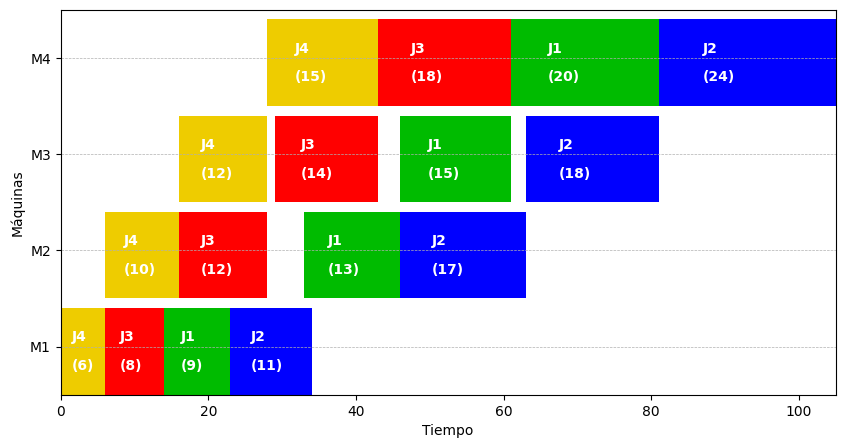

In [26]:
import pulp as lp
import numpy as np
import matplotlib.pyplot as plt

# Datos del problema
T = np.array([[9, 13, 15, 20],
              [11, 17, 18, 24],
              [8, 12, 14, 18],
              [6, 10, 12, 15]])

T = T.transpose()  # Transponer la matriz de tiempos para que las filas sean las máquinas y las columnas los trabajos

N = len(T[0])  # Número de trabajos (columnas)
M = len(T)  # Número de máquinas (filas)

# Crear el problema de LP
model_manne = lp.LpProblem("Manne_Model", lp.LpMinimize)

# Definir la constante P de penalización máxima
P = 100000

# Definir las variables de decisión
C = lp.LpVariable.dicts("C", (range(M), range(N)), lowBound=0, cat='Integer') # Tiempo de la tarea C_ij
D = lp.LpVariable.dicts("D", (range(N), range(N)), cat='Binary')
C_max = lp.LpVariable("C_max", lowBound=0, cat='Integer')

# Definir la función objetivo
model_manne += C_max

# Definir las restricciones
# (1)  El tiempo de inicio de la tarea i(columna i) en la primera máquina(fila 0) debe ser mayor o igual al tiempo de procesamiento de esa tarea en la primera máquina.
for i in range(N):
    model_manne += C[0][i] >= T[0][i]

# (2) el tiempo de procesamiento de la tarea i (columna i) en la máquina r(fila r) debe ser mayor o igual al tiempo de procesamiento de esa tarea en la máquina r−1.
for r in range(1, M):
    for i in range(N):
        model_manne += C[r][i] - C[r-1][i] >= T[r][i]

# (3) el tiempo de procesamiento de la tarea i (columna i) en la máquina r(fila r) debe ser mayor o igual al tiempo de procesamiento de la tarea k(columna k) en la misma máquina (fila r)
#considerando la penalización P*Dik
for r in range(M):
    for i in range(N):
        for k in range(i + 1, N):
            model_manne += C[r][i] - C[r][k] + P * D[i][k] >= T[r][i]

# (4) igual que (3), pero la penalización máxima debe ser menor o igual a  el tiempo de procesamiento de la tarea k (columna k) en la máquina r (fila r)
for r in range(M):
    for i in range(N):
        for k in range(i + 1, N):
            model_manne += C[r][i] - C[r][k] + P * D[i][k] <= P - T[r][k]

# (5) El tiempo total de finalización Cmax debe ser mayor o igual al tiempo de procesamiento de la tarea i(columna i) en la última máquina(M-1)
for i in range(N):
    model_manne += C_max >= C[M-1][i]

# Resolver el problema de LP
solution_manne = model_manne.solve()

# Imprimir la solución óptima
print("Objective Value:", lp.value(model_manne.objective))

# Carta Gannt
matriz = []
for r in range(M):
    maquina = []
    for i in range(N):
        maquina.append([int(lp.value(C[r][i]) - T[r][i]),int(lp.value(C[r][i]))])
    matriz.append(maquina)

fig, gantt = plt.subplots(figsize=(10, 5))
gantt.set_xlabel('Tiempo')
gantt.set_ylabel('Máquinas')
gantt.set_xlim(0, lp.value(model_manne.objective))
gantt.set_ylim(0, M * 10)
gantt.set_yticks(np.arange(5, M * 10, 10))
gantt.set_yticklabels(['M' + str(i) for i in range(1, M+1)])
gantt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
colores = ['#00BB00', 'blue', 'red', '#EECC00']

for r in range(M):
    for j in range(N):
        inicio = matriz[r][j][0]
        duracion = matriz[r][j][1] - matriz[r][j][0]
        gantt.broken_barh([(inicio, duracion)], ((r) * 10, 9), facecolors=colores[j])
        gantt.text(x=(inicio + duracion/4), y=((r) * 10 + 6), s='J'+str(j+1), va='center', color='white', fontweight='bold')
        gantt.text(x=(inicio + duracion/4), y=((r) * 10 + 3), s='('+str(duracion)+')', va='center', color='white', fontweight='bold') 

#### Implementación con CPLEX

Objective Value: 105.0


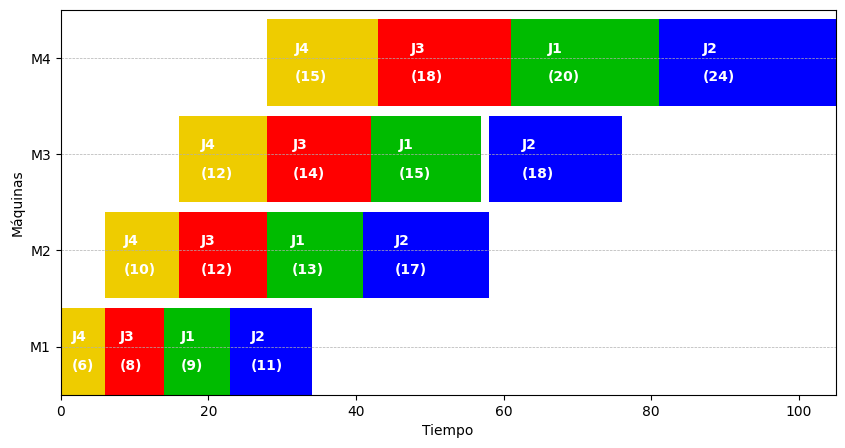

In [27]:
from docplex.mp.model import Model
import numpy as np
import matplotlib.pyplot as plt

# Datos del problema
T = np.array([[9, 13, 15, 20],
              [11, 17, 18, 24],
              [8, 12, 14, 18],
              [6, 10, 12, 15]])

T = T.transpose()  # maquinas x trabajos

N = len(T[0])  # Número de trabajos (filas)
M = len(T)  # Número de máquinas (columnas)

# Crear el modelo de CPLEX
model_cplex = Model(name="Manne_Model")

# Definir la constante P de penalización máxima
P = 100000

# Definir las variables de decisión
C = {(r, i): model_cplex.integer_var(name=f"C_{r}_{i}") for r in range(M) for i in range(N)}
D = {(i, k): model_cplex.binary_var(name=f"D_{i}_{k}") for i in range(N) for k in range(N)}
C_max = model_cplex.integer_var(name="C_max")

# Definir la función objetivo
model_cplex.minimize(C_max)

# Definir las restricciones
# (13)  El tiempo de inicio de la tarea i (columna i) en la primera máquina (fila 0) debe ser mayor o igual al tiempo de procesamiento de esa tarea en la primera máquina.
for i in range(N):
    model_cplex.add_constraint(C[0, i] >= T[0][i])

# (14) el tiempo de procesamiento de la tarea i (columna i) en la máquina r (fila r) debe ser mayor o igual al tiempo de procesamiento de esa tarea en la máquina r−1.
for r in range(1, M):
    for i in range(N):
        model_cplex.add_constraint(C[r, i] - C[r - 1, i] >= T[r][i])

# (15) el tiempo de procesamiento de la tarea i (columna i) en la máquina r (fila r) debe ser mayor o igual al tiempo de procesamiento de la tarea k (columna k) en la misma máquina (fila r)
# considerando la penalización P*Dik
for r in range(M):
    for i in range(N):
        for k in range(i + 1, N):
            model_cplex.add_constraint(C[r,i] - C[r,k] + P * D[i,k] >= T[r][i])

# (16) igual que (3), pero la penalización máxima debe ser menor o igual a  el tiempo de procesamiento de la tarea k (columna k) en la máquina r (fila r)
for r in range(M):
    for i in range(N):
        for k in range(i + 1, N):
            model_cplex.add_constraint(C[r, i] - C[r, k] + P * D[i, k] <= P - T[r][k])

# (5) El tiempo total de finalización Cmax debe ser mayor o igual al tiempo de procesamiento de la tarea i (columna i) en la última máquina(M-1)
for i in range(N):
    model_cplex.add_constraint(C_max >= C[M-1,i])

# Resolver el problema con CPLEX
solution_cplex = model_cplex.solve()

# Imprimir la solución óptima
print("Objective Value:", model_cplex.objective_value)

# Carta Gannt
matriz = []
for r in range(M):
    maquina = []
    for i in range(N):
        maquina.append([int(C[r,i].solution_value - T[r][i]),int(C[r,i].solution_value)])
    matriz.append(maquina)

fig, gantt = plt.subplots(figsize=(10, 5))
gantt.set_xlabel('Tiempo')
gantt.set_ylabel('Máquinas')
gantt.set_xlim(0, model_cplex.objective_value)
gantt.set_ylim(0, M * 10)
gantt.set_yticks(np.arange(5, M * 10, 10))
gantt.set_yticklabels(['M' + str(i) for i in range(1, M+1)])
gantt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
colores = ['#00BB00', 'blue', 'red', '#EECC00']

for r in range(M):
    for j in range(N):
        inicio = matriz[r][j][0]
        duracion = matriz[r][j][1] - matriz[r][j][0]
        gantt.broken_barh([(inicio, duracion)], ((r) * 10, 9), facecolors=colores[j])
        gantt.text(x=(inicio + duracion/4), y=((r) * 10 + 6), s='J'+str(j+1), va='center', color='white', fontweight='bold')
        gantt.text(x=(inicio + duracion/4), y=((r) * 10 + 3), s='('+str(duracion)+')', va='center', color='white', fontweight='bold') 

#### Implementación con GUROBI

Objective Value: 105.0


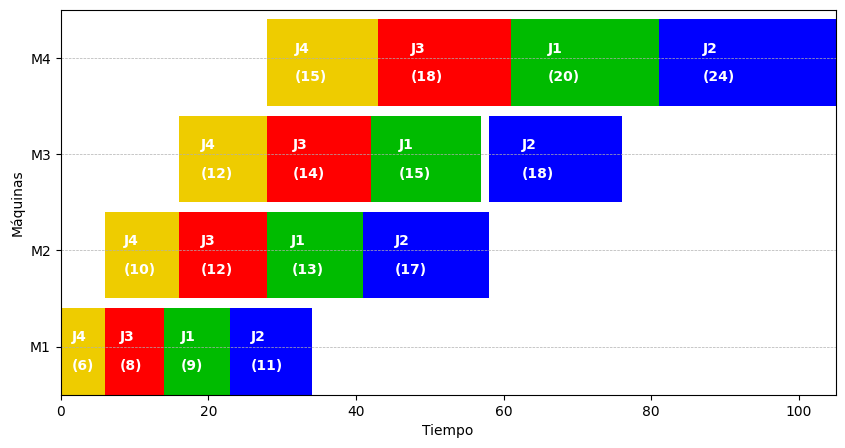

In [28]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt

# Datos del problema
T = np.array([[9, 13, 15, 20],
              [11, 17, 18, 24],
              [8, 12, 14, 18],
              [6, 10, 12, 15]])

# El modelo está definido usando las máquinas como filas y los tiempos de ejecución como columnas
T = T.transpose()  # maquinas x trabajos

N = len(T[0])  # Número de trabajos (filas)
M = len(T)     # Número de máquinas (columnas)

# Crear el problema de LP
model_manne = gp.Model("Manne_Model")

# Definir la constante P de penalización máxima
P = 100000

# Definir las variables de decisión
C = model_manne.addVars(range(M), range(N), lb=0, vtype=GRB.INTEGER, name="C")
D = model_manne.addVars(range(N), range(N), vtype=GRB.BINARY, name="D")
C_max = model_manne.addVar(lb=0, vtype=GRB.INTEGER, name="C_max")

# Definir la función objetivo
model_manne.setObjective(C_max, sense=GRB.MINIMIZE)

# Definir las restricciones
# (1) El tiempo de inicio de la tarea i (columna i) en la primera máquina (fila 0) debe ser mayor o igual al tiempo de procesamiento de esa tarea en la primera máquina.
for i in range(N):
    model_manne.addConstr(C[0, i] >= T[0][i])

# (2) El tiempo de procesamiento de la tarea i (columna i) en la máquina r (fila r) debe ser mayor o igual al tiempo de procesamiento de esa tarea en la máquina r−1.
for r in range(1, M):
    for i in range(N):
        model_manne.addConstr(C[r, i] - C[r - 1, i] >= T[r, i])

# (3) El tiempo de procesamiento de la tarea i (columna i) en la máquina r (fila r) debe ser mayor o igual al tiempo de procesamiento de la tarea k (columna k) en la misma máquina (fila r)
# considerando la penalización P*Dik
for r in range(M):
    for i in range(N):
        for k in range(i + 1, N):
            model_manne.addConstr(C[r, i] - C[r, k] + P * D[i, k] >= T[r][i])

# (4) Igual que (3), pero la penalización máxima debe ser menor o igual a  el tiempo de procesamiento de la tarea k (columna k) en la máquina r (fila r)
for r in range(M):
    for i in range(N - 1):
        for k in range(i + 1, N):
            model_manne.addConstr(C[r, i] - C[r, k] + P * D[i, k] <= P - T[r][k])

# (5) El tiempo total de finalización Cmax debe ser mayor o igual al tiempo de procesamiento de la tarea i (columna i) en la última máquina (M-1)
for i in range(N):
    model_manne.addConstr(C_max >= C[M-1,i])

# Resolver el problema de LP
model_manne.setParam('OutputFlag', False)
model_manne.optimize()

# Imprimir la solución óptima
print("Objective Value:", model_manne.objVal)

# Carta Gannt
matriz = []
for r in range(M):
    maquina = []
    for i in range(N):
        maquina.append([int(C[r,i].x - T[r][i]),int(C[r,i].x)])
    matriz.append(maquina)

fig, gantt = plt.subplots(figsize=(10, 5))
gantt.set_xlabel('Tiempo')
gantt.set_ylabel('Máquinas')
gantt.set_xlim(0, model_manne.objVal)
gantt.set_ylim(0, M * 10)
gantt.set_yticks(np.arange(5, M * 10, 10))
gantt.set_yticklabels(['M' + str(i) for i in range(1, M+1)])
gantt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
colores = ['#00BB00', 'blue', 'red', '#EECC00']

for r in range(M):
    for j in range(N):
        inicio = matriz[r][j][0]
        duracion = matriz[r][j][1] - matriz[r][j][0]
        gantt.broken_barh([(inicio, duracion)], ((r) * 10, 9), facecolors=colores[j])
        gantt.text(x=(inicio + duracion/4), y=((r) * 10 + 6), s='J'+str(j+1), va='center', color='white', fontweight='bold')
        gantt.text(x=(inicio + duracion/4), y=((r) * 10 + 3), s='('+str(duracion)+')', va='center', color='white', fontweight='bold') 


### Modelo Liao-You
$$ Min \quad C_{max}$$
$$ \text{s.a} \quad S_{ri} + T_{ri} \leq S_{r+1,i}; \quad (i<= i <= N), \quad (1)$$

#### Implementación en PuLP

Valor óptimo (Cmax): 105.0


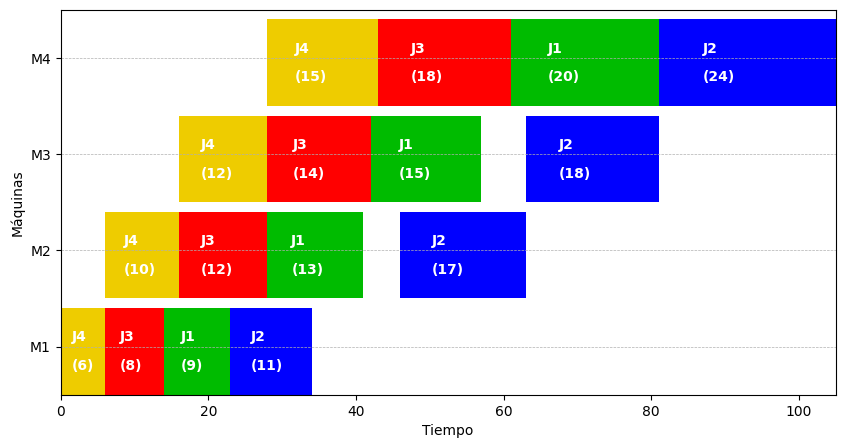

In [29]:
import pulp as lp
import numpy as np
import matplotlib.pyplot as plt

# Datos proporcionados
T = np.array([[9, 13, 15, 20],
              [11, 17, 18, 24],
              [8, 12, 14, 18],
              [6, 10, 12, 15]])
T = T.transpose()
T = T.tolist()

N = len(T)  # Número de trabajos
M = len(T[0])  # Número de máquinas
P = 100000  # Una constante grande, suficiente para actuar como 'M' en el modelo

# Crear el modelo
model = lp.LpProblem("Liao-You_Model", lp.LpMinimize)

# Definir las variables
D = lp.LpVariable.dicts("D", (range(N), range(N)), cat='Binary')
S = lp.LpVariable.dicts("S", (range(M), range(N)), lowBound=0, cat='Integer')
q = lp.LpVariable.dicts("q", (range(M), range(N), range(N)), lowBound=0,cat='Integer')
C_max = lp.LpVariable("C_max", lowBound=0, cat='Integer')

# Función objetivo
model += C_max

# Restricciones

# Flujo de trabajos en cada máquina
for r in range(M-1):
    for i in range(N):
        model += S[r][i] + T[r][i] <= S[r+1][i], f"Job_Flow_{i}_{r}"

# Secuencia de trabajos en cada máquina
for r in range(M):
    for i in range(N):
        for k in range(i+1, N):
            model += S[r][i] - S[r][k] + P * D[i][k] - T[r][k] == q[r][i][k], f"Job_Sequence_{r}_{i}_{k}"

# Precedencia de trabajos en las máquinas
for r in range(M):
    for i in range(N):
        for k in range(i+1, N):           
            model += P - T[r][i] - T[r][k] >= q[r][i][k], f"Surplus_Positive_{r}_{i}_{k}"

# Restricciones de makespan
for i in range(N):
    model += C_max >= S[M-1][i] + T[M-1][i], f"Job_Completion_{i}"

# Resolver el modelo
model.solve()

# Imprimir la solución
print(f"Valor óptimo (Cmax): {model.objective.value()}")

# Carta gantt
matriz = []
for r in range(M):
    maquina = []
    for i in range(N):
        maquina.append([int(lp.value(S[r][i])),int(lp.value(S[r][i]) + T[r][i])])
    matriz.append(maquina)

fig, gantt = plt.subplots(figsize=(10, 5))
gantt.set_xlabel('Tiempo')
gantt.set_ylabel('Máquinas')
gantt.set_xlim(0, lp.value(model.objective))
gantt.set_ylim(0, M * 10)
gantt.set_yticks(np.arange(5, M * 10, 10))
gantt.set_yticklabels(['M' + str(i) for i in range(1, M+1)])
gantt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
colores = ['#00BB00', 'blue', 'red', '#EECC00']

for r in range(M):
    for j in range(N):
        inicio = matriz[r][j][0]
        duracion = matriz[r][j][1] - matriz[r][j][0]
        gantt.broken_barh([(inicio, duracion)], ((r) * 10, 9), facecolors=colores[j])
        gantt.text(x=(inicio + duracion/4), y=((r) * 10 + 6), s='J'+str(j+1), va='center', color='white', fontweight='bold')
        gantt.text(x=(inicio + duracion/4), y=((r) * 10 + 3), s='('+str(duracion)+')', va='center', color='white', fontweight='bold') 

#### Implementación en CPLEX

Objective Value: 105.0


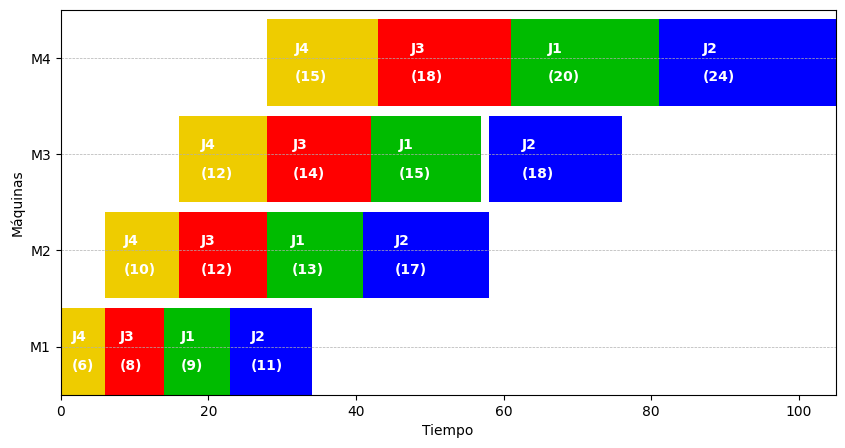

In [30]:
from docplex.mp.model import Model
import numpy as np
import matplotlib.pyplot as plt

# Datos proporcionados
T = np.array([[9, 13, 15, 20],
              [11, 17, 18, 24],
              [8, 12, 14, 18],
              [6, 10, 12, 15]])
T = T.transpose()

N = len(T[0])  # Número de trabajos
M = len(T)     # Número de máquinas
P = 100000  # Una constante grande, suficiente para actuar como 'M' en el modelo


# Crear el modelo
model_cplex = Model(name="Liao-You_Model")

# Definir las variables
D = {(i, k): model_cplex.binary_var(name=f"D_{i}_{k}") for i in range(N) for k in range(N)}
S = {(r, i): model_cplex.integer_var(name=f"S_{r}_{i}") for r in range(M) for i in range(N)}
q = {(r, i, k): model_cplex.integer_var(name=f"q_{r}_{i}_{k}") for r in range(M) for i in range(N) for k in range(N)}
C_max = model_cplex.integer_var(name="C_max")

# Función objetivo
model_cplex.minimize(C_max)

# Restricciones
# Flujo de trabajos en cada máquina
for r in range(M-1):
    for i in range(N):
        model_cplex.add_constraint(S[r, i] + T[r][i] <= S[r+1, i])


# Secuencia de trabajos en cada máquina
for r in range(M):
    for i in range(N):
        for k in range(i+1, N):
            model_cplex.add_constraint(S[r, i] - S[r, k] + P * D[i, k] - T[r][k] == q[r, i, k])

# Precedencia de trabajos en las máquinas
for r in range(M):
    for i in range(N):
        for k in range(i+1, N):  
            model_cplex.add_constraint(P - T[r][i] - T[r][k] >= q[r, i, k])         

# Restricciones de makespan
for i in range(N):
    model_cplex.add_constraint(C_max >= S[M-1, i] + T[M-1][i])

# Resolver el modelo
solution_cplex = model_cplex.solve()

# Imprimir la solución
print("Objective Value:", model_cplex.objective_value)

# Carta Gannt
matriz = []
for r in range(M):
    maquina = []
    for i in range(N):
        maquina.append([int(S[r,i].solution_value),int(S[r,i].solution_value + T[r][i])])
    matriz.append(maquina)

fig, gantt = plt.subplots(figsize=(10, 5))
gantt.set_xlabel('Tiempo')
gantt.set_ylabel('Máquinas')
gantt.set_xlim(0, model_cplex.objective_value)
gantt.set_ylim(0, M * 10)
gantt.set_yticks(np.arange(5, M * 10, 10))
gantt.set_yticklabels(['M' + str(i) for i in range(1, M+1)])
gantt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
colores = ['#00BB00', 'blue', 'red', '#EECC00']

for r in range(M):
    for j in range(N):
        inicio = matriz[r][j][0]
        duracion = matriz[r][j][1] - matriz[r][j][0]
        gantt.broken_barh([(inicio, duracion)], ((r) * 10, 9), facecolors=colores[j])
        gantt.text(x=(inicio + duracion/4), y=((r) * 10 + 6), s='J'+str(j+1), va='center', color='white', fontweight='bold')
        gantt.text(x=(inicio + duracion/4), y=((r) * 10 + 3), s='('+str(duracion)+')', va='center', color='white', fontweight='bold') 

#### Implementación en GUROBI

Valor óptimo (Cmax): 105.0


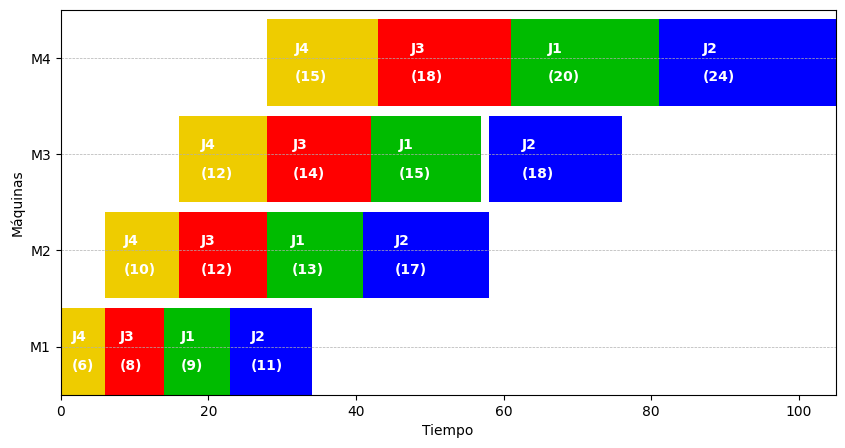

In [31]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt

# Datos proporcionados
T = np.array([[9, 13, 15, 20],
              [11, 17, 18, 24],
              [8, 12, 14, 18],
              [6, 10, 12, 15]])
T = T.transpose()
T = T.tolist()

N = len(T[0])  # Número de trabajos
M = len(T)  # Número de máquinas
P = 100000  # Una constante grande, suficiente para actuar como 'M' en el modelo

# Crear el modelo
model = gp.Model("Liao-You_Model")

# Definir las variables
D = model.addVars(range(N), range(N), vtype=GRB.BINARY, name="D")
S = model.addVars(range(M), range(N), lb=0, vtype=GRB.INTEGER, name="S")
q = model.addVars(range(M), range(N), range(N), lb=0, vtype=GRB.INTEGER, name="q")
C_max = model.addVar(lb=0, vtype=GRB.INTEGER, name="C_max")

# Función objetivo
model.setObjective(C_max, sense=GRB.MINIMIZE)

# Restricciones

# Flujo de trabajos en cada máquina
for r in range(M-1):
    for i in range(N):
        model.addConstr(S[r,i] + T[r][i] <= S[r+1,i], f"Job_Flow_{i}_{r}")

# Secuencia de trabajos en cada máquina
for r in range(M):
    for i in range(N):
        for k in range(i+1, N):
            model.addConstr(S[r,i] - S[r,k] + P * D[i,k] - T[r][k] == q[r,i,k], f"Job_Sequence_{r}_{i}_{k}")

# Precedencia de trabajos en las máquinas
for r in range(M):
    for i in range(N):
        for k in range(i+1, N):
            model.addConstr(P - T[r][i] - T[r][k] >= q[r,i,k])

# Restricciones de makespan
for i in range(N):
    model.addConstr(C_max >= S[M-1,i] + T[M-1][i], f"Job_Completion_{i}")

# Resolver el modelo
model.setParam('OutputFlag', False)
model.optimize()

# Imprimir la solución
print(f"Valor óptimo (Cmax): {model.objVal}")

# Carta Gantt
matriz = []
for r in range(M):
    maquina = []
    for i in range(N):
        maquina.append([int(S[r,i].x), int(S[r,i].x + T[r][i])])
    matriz.append(maquina)

fig, gantt = plt.subplots(figsize=(10, 5))
gantt.set_xlabel('Tiempo')
gantt.set_ylabel('Máquinas')
gantt.set_xlim(0, model.objVal)
gantt.set_ylim(0, M * 10)
gantt.set_yticks(np.arange(5, M * 10, 10))
gantt.set_yticklabels(['M' + str(i) for i in range(1, M+1)])
gantt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
colores = ['#00BB00', 'blue', 'red', '#EECC00']

for r in range(M):
    for j in range(N):
        inicio = matriz[r][j][0]
        duracion = matriz[r][j][1] - matriz[r][j][0]
        gantt.broken_barh([(inicio, duracion)], ((r) * 10, 9), facecolors=colores[j])
        gantt.text(x=(inicio + duracion/4), y=((r) * 10 + 6), s='J'+str(j+1), va='center', color='white', fontweight='bold')
        gantt.text(x=(inicio + duracion/4), y=((r) * 10 + 3), s='('+str(duracion)+')', va='center', color='white', fontweight='bold')
